# DL20191921: Initial analysis of hemichordate 10x pilot experiment

## Modules and functions

In [51]:
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import CategoricalDtype
from pandas.api.types import CategoricalDtype, is_categorical_dtype

import scipy.sparse as sp_sparse
import h5py
import tqdm
import scanpy as sc

sc.settings.verbosity = 3 
sc.logging.print_versions()

np.random.seed(0)

FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['feature_ids', 'feature_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename):
    with h5py.File(filename) as f:
        if u'version' in f.attrs:
            if f.attrs['version'] > 2:
                raise ValueError('Matrix HDF5 file format version (%d) is an newer version that is not supported by this function.' % version)
        else:
            raise ValueError('Matrix HDF5 file format version (%d) is an older version that is not supported by this function.' % version)
        
        feature_ids = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['id']]
        feature_names = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['name']]        
        barcodes = list(f['matrix']['barcodes'][:])
        matrix = sp_sparse.csc_matrix((f['matrix']['data'], f['matrix']['indices'], f['matrix']['indptr']), shape=f['matrix']['shape'])
        return FeatureBCMatrix(feature_ids, feature_names, barcodes, matrix)

def get_expression(fbm, gene_name):
    try:
        gene_index = feature_bc_matrix.feature_names.index(gene_name)
    except ValueError:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return fbm.matrix[gene_index, :].toarray().squeeze()

def process_adata(adata):
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=750)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.log1p(adata)
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    adata = adata[:, adata.var['highly_variable']]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata)
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
    sc.tl.louvain(adata, resolution = 0.2)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color = 'louvain')

    return adata


scanpy==1.4.2 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.1 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1 


## Ingest and process cell x gene matrix

In [2]:
nonsorted_adata = sc.read_10x_mtx(
    '/home/ubuntu/data/hemichordate/analysis/nonsorted/',
    var_names='gene_symbols', 
    cache=True)
nonsorted_adata.obs['sort'] = False


Trying to set attribute `.obs` of view, making a copy.


... reading from cache file cache/home-ubuntu-data-hemichordate-analysis-nonsorted-matrix.h5ad


In [52]:
def prepare_dataframe(adata, var_names, groupby=None, use_raw=None, log=False, num_categories=7):
    """
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse
#     sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None: use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError('groupby has to be a valid observation. Given value: {}, '
                             'valid observations: {}'.format(groupby, adata.obs_keys()))

    if use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    categories = obs_tidy.index.categories

    return categories, obs_tidy

In [27]:
merge_adata.obs['placeholder'] = (merge_adata.obs['placeholder']
                                  .astype(CategoricalDtype(['hi']))
                                 )


In [48]:
merge_adata.obs['cellid'] = merge_adata.obs.index.tolist()
merge_adata.obs['cellid'] = merge_adata.obs['cellid'].astype('category')


In [53]:
cat, df = prepare_dataframe(merge_adata, var_names=['en','LOC100368163'], groupby='cellid')

In [54]:
df

,en,LOC100368163
cellid,,
AAAGAACTCCGTGGCA-1-0,0.0,0.0
AAATGGAAGTGGCGAT-1-0,0.0,0.0
AAATGGATCAAGCTGT-1-0,0.0,0.0
AAATGGATCGTACACA-1-0,0.0,0.0
AAGAACAGTCAACACT-1-0,0.0,0.0
...,...,...
TTTCCTCAGATGGTCG-1-1,0.0,0.0
TTTCCTCTCCGCACTT-1-1,0.0,0.0
TTTCGATGTCAGTCCG-1-1,0.0,0.0


In [39]:
df['n_genes'] = merge_adata.obs['n_genes']

In [40]:
df

,en,LOC100368163,n_genes
,0.0,0.0,NaN
,0.0,0.0,NaN
,0.0,0.0,NaN
,0.0,0.0,NaN
,0.0,0.0,NaN
...,...,...,...
,0.0,0.0,NaN
,0.0,0.0,NaN
,0.0,0.0,NaN
,0.0,0.0,NaN


Trying to set attribute `.obs` of view, making a copy.


... reading from cache file cache/home-ubuntu-data-hemichordate-analysis-nonsorted-matrix.h5ad
... reading from cache file cache/home-ubuntu-data-hemichordate-analysis-sorted-matrix.h5ad


Trying to set attribute `.obs` of view, making a copy.


filtered out 1053 cells that have less than 750 genes expressed
filtered out 15511 genes that are detected in less than 3 cells
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


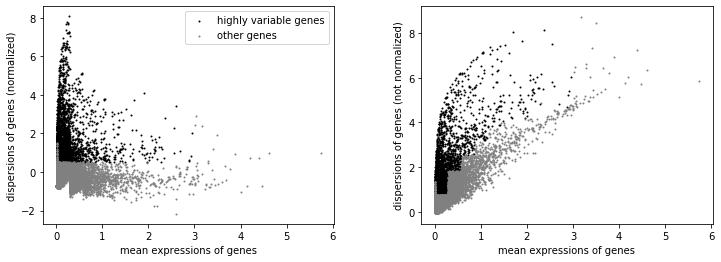

computing PCA with n_comps = 50
computing PCA on highly variable genes


... storing 'feature_types' as categorical


    finished (0:00:00.21)


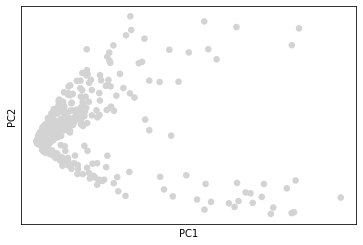

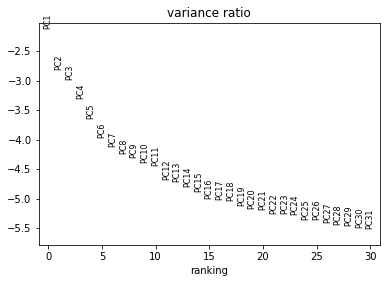

computing neighbors
    using 'X_pca' with n_pcs = 20


/home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nop

    finished (0:00:02.45) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.03) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
computing UMAP
    using 'X_pca' with n_pcs = 20
    finished (0:00:03.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)


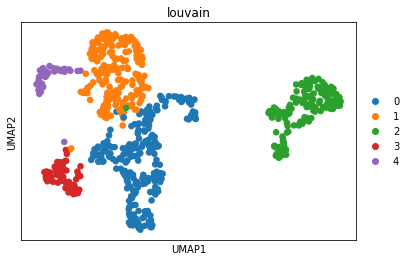

In [4]:
# unsorted channel
nonsorted_adata = sc.read_10x_mtx(
    '/home/ubuntu/data/hemichordate/analysis/nonsorted/',
    var_names='gene_symbols', 
    cache=True)
nonsorted_adata.obs['sort'] = False

# sorted channel
sorted_adata = sc.read_10x_mtx(
    '/home/ubuntu/data/hemichordate/analysis/sorted/',
    var_names='gene_symbols', 
    cache=True)
sorted_adata.obs['sort'] = True

# concat both sorted and unsorted channels
merge_adata = nonsorted_adata.concatenate(sorted_adata)
merge_adata.obs['sort'] = (merge_adata.obs['sort']
                           .astype(str)
                           .astype(CategoricalDtype(['True','False']))
                          )

# generic processing
merge_adata = process_adata(merge_adata)


## Unsorted channel results

No detected transgene transcripts.

Weak engrailed signal.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


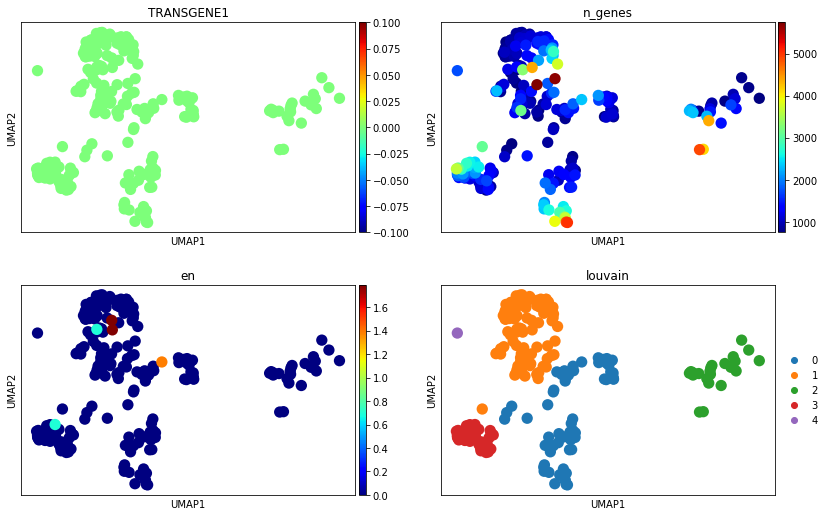

In [3]:
sc.pl.umap(merge_adata[merge_adata.obs['sort'] == 'False'], 
           color=['TRANSGENE1', 'n_genes','en','louvain'],
           ncols=2,
           cmap='jet'
          )


## Sorted channel results

Weak transgene signal, mostly in Louvain cluster 1.

Low-medium expression of engrailed in Louvain cluster 1.

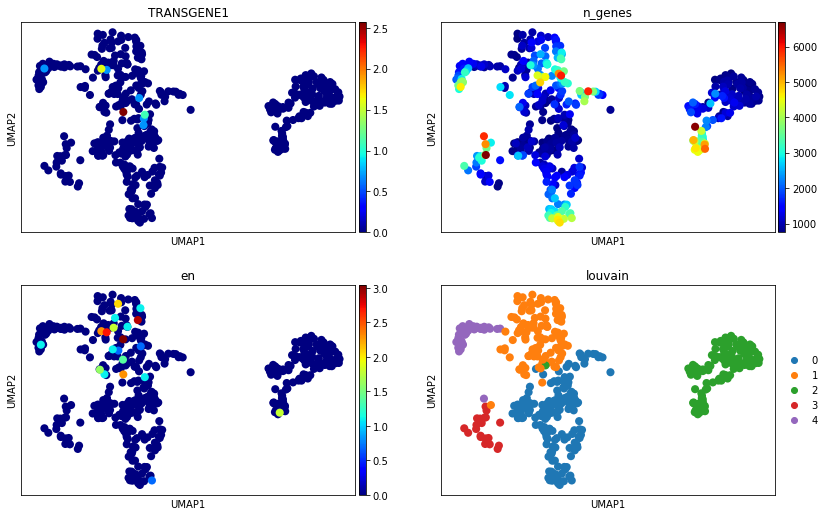

In [4]:
sc.pl.umap(merge_adata[merge_adata.obs['sort'] == 'True'], 
           color=['TRANSGENE1', 'n_genes','en','louvain'],
           ncols=2,
           cmap='jet'
          )


## Merged channels results

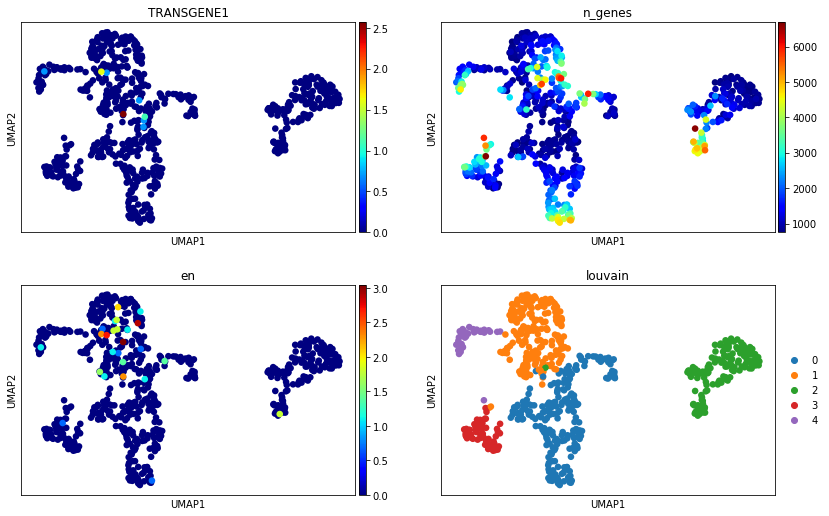

In [5]:
sc.pl.umap(merge_adata, 
           color=['TRANSGENE1', 'n_genes','en','louvain'],
           ncols=2,
           cmap='jet'
          )

## Differential analysis

In [6]:
# ingest GTF to convert gene names
gtf_df = pd.read_csv('/home/ubuntu/data/hemichordate/hemichordate.gtf', sep='\t', header=None)
gtf_df.columns = ['scaffold','scaffold_name','gene_feature','start','end','score','strand','unk','annotations']
gtf_df['product_field'] = [any([x.startswith('product ') for x in x.split('; ')]) for x in gtf_df['annotations']]
prod_yes = gtf_df[gtf_df['product_field'] == True]
prod_yes['product_desc'] = [subx[9:-1] \
                            for x in prod_yes['annotations'] \
                            for subx in x.split('; ') if subx.startswith('product ')
                           ]
prod_yes['gene_field'] = [any([x.startswith('gene ') for x in x.split('; ')]) for x in prod_yes['annotations']]
gene_yes = prod_yes[prod_yes['gene_field'] == True]
gene_yes['value'] = [subx[6:-1] \
                            for x in gene_yes['annotations'] \
                            for subx in x.split('; ') if subx.startswith('gene ')
                           ]
gene_yes = gene_yes[~gene_yes['value'].duplicated('first')]

# Wilcoxon test
sc.tl.rank_genes_groups(merge_adata,
                        groupby='louvain', 
                        method='wilcoxon',
                        n_genes = 100)
de_df = pd.DataFrame(merge_adata.uns['rank_genes_groups']['names'])
de_df['idx'] = [x for x in range(len(de_df))]
de_df = pd.melt(de_df,id_vars= 'idx')
de_df = pd.merge(de_df, gene_yes.loc[:,['product_desc','value']], 'left', 'value')

# output results for cluster 1
pd.options.display.max_rows = 100
de_df[de_df.variable == '1']

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

ranking genes
    finished (0:00:00.74) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


,idx,variable,value,product_desc
100,0,1,LOC100329022,dorsal switch-like hmg protein
101,1,1,LOC100373248,complexin-like%2C transcript variant X2
102,2,1,LOC102806702,uncharacterized LOC102806702
103,3,1,LOC100377101,guanine nucleotide-binding protein G(o) subuni...
104,4,1,LOC100372178,ras-related protein Rab-3-like%2C transcript v...
105,5,1,LOC100376664,caldesmon-like
106,6,1,LOC100313728,secretogranin 7B2-like protein
107,7,1,LOC100373523,voltage-dependent P/Q-type calcium channel sub...
108,8,1,LOC100371111,nucleolysin TIA-1 isoform p40-like%2C transcri...
109,9,1,LOC100313746,synaptotagmin 1
